# Graph convolutional network development for the toy 2D data

This notebook is for some preliminary development for graph conv models.

There are a variety of ways to construct neural network graph operations which resemble convolutions. Here are a few possible "kernels":
- $\tilde{X} = \sigma(X W_0 + D X W_1 + A X W_2)$, where A is the adjacency matrix containing edge weights, D is the diagonal degree matrix, and the $W$s are learnable weight matrices.
- $\tilde{X} = \sigma(D^{-1}A X W)$, where $D^{-1}A$ is the normalized adjacency matrix.
- $\tilde{X} = \sigma(\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}} X W)$, where $\hat{A} = A + I$ and $\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}}$ is the symmetrically normalized adjacency matrix.

In [1]:
# System imports
from __future__ import print_function

# Externals
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

## Data generation

In [2]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n)
    xout = np.random.uniform(size=n)
    #slopes = (xout - xin) / (det_r.shape[0] - 1)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def transform_hits(x):
    """
    Sorts and transposes track hit coordinates.
    
    Given an array of hit positions with shape (num_track, num_layer),
    this function returns the hit positions per detector layer with shape
    (num_layer, num_track)
    """
    idx = np.argsort(x, axis=0)
    img = x[idx, np.arange(x.shape[1])]
    return img.T, idx.T

## Generate and visualize some data

In [3]:
# Detector config
det_r = np.array([0, 1, 2, 3], dtype=np.float)
#det_r = np.array([0, 1, 2, 3, 4, 6, 8, 10, 12, 14], dtype=float)
num_det_layers = det_r.shape[0]

# Data config
num_tracks = 5

# Generate an example event
x = gen_tracks(num_tracks, det_r)
hits_x, hits_pid = transform_hits(x)
hits_r = np.zeros_like(hits_x)
hits_r[:] = det_r[:,None]

<IPython.core.display.Javascript object>


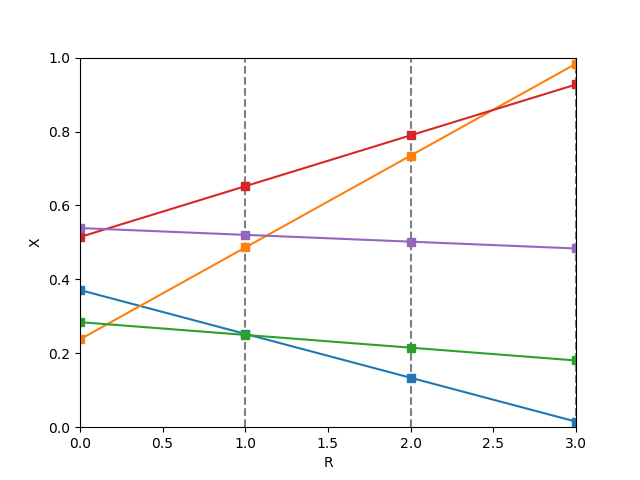

In [4]:
# Visualize the tracks
plt.figure()
for r in det_r:
    plt.plot([r, r], [0, 1], 'k--', alpha=0.5)
for i in range(x.shape[0]):
    plt.plot(det_r, x[i], 's-')
    plt.xlim((0, det_r[-1]))
    plt.ylim((0, 1))
    plt.xlabel('R')
    plt.ylabel('X')

## Adjacency development

Let's work on constructing adjacency and degree matrices.

The appropriate adjacency weight matrix for this data should work as follows:
- if the line between two hits on adjacent layers is fully contained in the detector, the adjacency is 1
- otherwise the adjacency is 0

In [5]:
hits_l = np.zeros_like(hits_x)
hits_l[:] = np.arange(0, num_det_layers)[:, None]
print('Position x')
print(hits_x)
print('Position r')
print(hits_r)
print('Layer')
print(hits_l)
print('Particle ID')
print(hits_pid)

Position x
[[ 0.23776675  0.28423302  0.37115954  0.5145461   0.53878642]
 [ 0.2496803   0.25245695  0.486333    0.52037096  0.65210785]
 [ 0.13375437  0.21512759  0.5019555   0.73489925  0.78966959]
 [ 0.01505179  0.18057487  0.48354004  0.92723133  0.9834655 ]]
Position r
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]]
Layer
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]]
Particle ID
[[1 2 0 3 4]
 [2 0 1 4 3]
 [0 2 4 1 3]
 [0 2 4 3 1]]


In [6]:
# Flatten the arrays
x = hits_x.flatten()
r = hits_r.flatten()
l = hits_l.flatten()
pid = hits_pid.flatten()

In [7]:
# Identify hits on adjacent layers
adj_l = (np.abs(l[None, :] - l[:, None]) == 1).astype(np.int)

# Calculate slopes
dr = r[None,:] - r[:,None]
dr[dr == 0] = 1e-7
slope = (x[None,:] - x[:,None]) / dr

# Calculate the entry point for each slope
x0 = x[None,:] - slope*r
# Calculate the exit point for each slope
xn = x[None,:] + slope * (det_r[-1] - r)
# Adjancency
adj_x0 = (x0 < 1) & (x0 > 0)
adj_xn = (xn < 1) & (xn > 0)
# Final adjacency matrix
adj = adj_l * adj_x0 * adj_xn

# Get the true adjacency matrix
adj_pid = (pid[None, :] == pid[:, None]).astype(np.int)

<IPython.core.display.Javascript object>


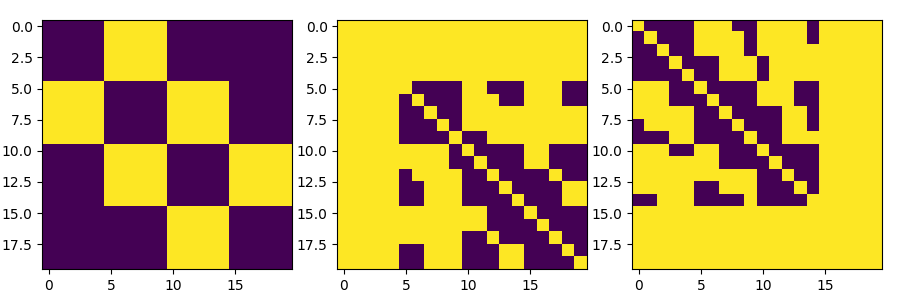

In [8]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(adj_l)
plt.subplot(132)
plt.imshow(adj_x0)
plt.subplot(133)
plt.imshow(adj_xn)
plt.tight_layout()

<IPython.core.display.Javascript object>


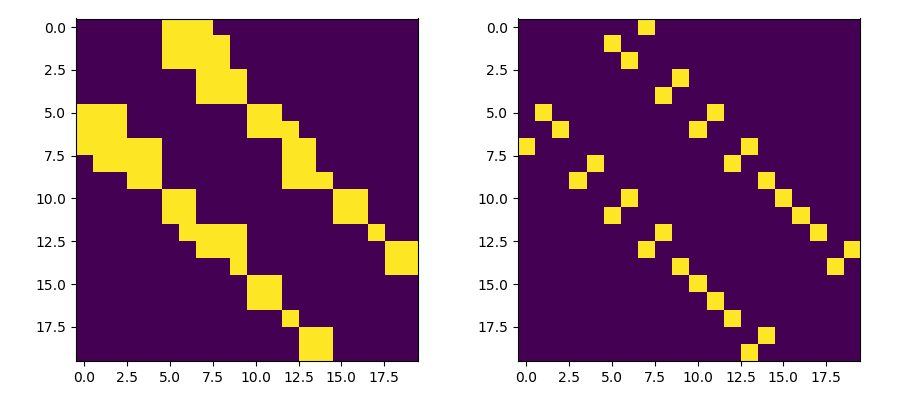

In [9]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(adj)
plt.subplot(122)
plt.imshow(adj_pid*adj_l)
plt.tight_layout()

<IPython.core.display.Javascript object>


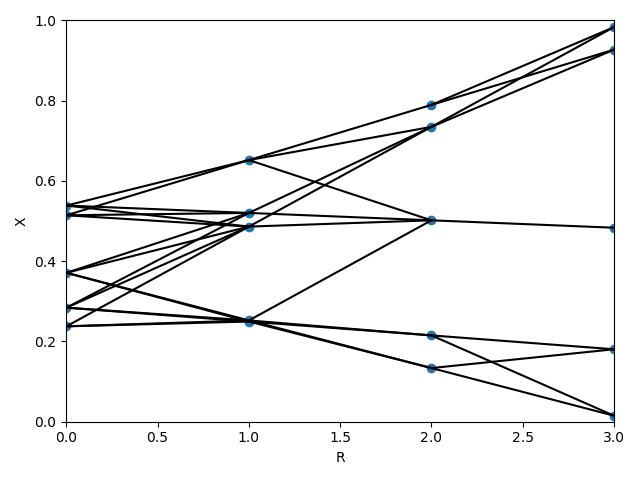

In [10]:
# Sanity check: need to draw these edges
plt.figure()

# Draw all the hits
plt.scatter(r, x)

# Loop over all hits
for i in range(x.shape[0]):
    # Loop over all other hits
    for j in range(i + 1, x.shape[0]):
        if adj[i,j] > 0:
            plt.plot([r[i], r[j]], [x[i], x[j]], 'k', alpha=adj[i,j])
plt.xlim((det_r[0], det_r[-1]))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
plt.tight_layout()

### Normalizing the adjacency

A typical thing to do is $D^{-1}A$, where $D$ is the diagonal degree matrix. This amounts to normalizing all edges coming into a node so they sum to 1.

The approach of Kipf and Welling is $\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}}$, where $\hat{A} = A + I$.

In [20]:
# The degree matrix is computed by summing the adjacency rows
deg = np.diagflat(adj.sum(axis=0))
#print(deg)

# Inverse degree matrix
invdeg = np.diagflat(1. / adj.sum(axis=0))
#print(invdeg)

adj_norm = invdeg.dot(adj)

In [21]:
adj_hat = np.eye(adj.shape[0]) + adj
inv_half_deg = np.diagflat(1. / np.sqrt(adj_hat.sum(axis=0)))
adj_hat_norm = inv_half_deg.dot(adj_hat.dot(inv_half_deg))

<IPython.core.display.Javascript object>


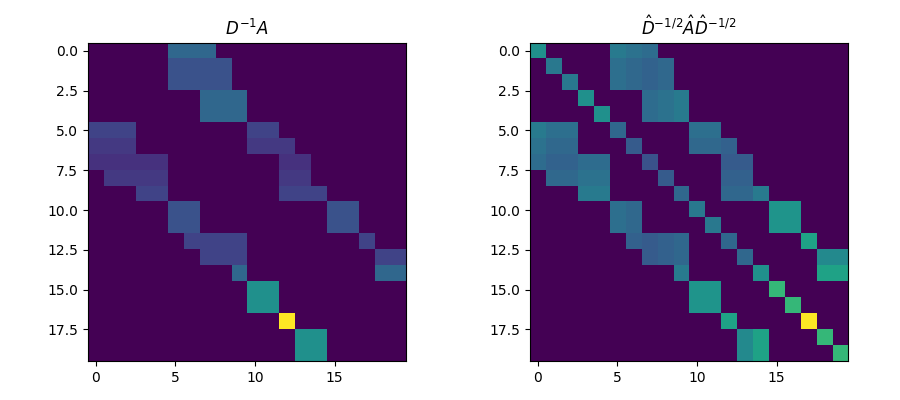

In [28]:
# Normalized adjacency matrix
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(adj_norm)
plt.title('$D^{-1}A$')

plt.subplot(122)
plt.imshow(adj_hat_norm)
plt.title('$\hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}$')
plt.tight_layout()

## Graph convolutional layer

Now let's try to put this into a forward pass of a single graph convolution layer using PyTorch.